# COMP 579: Assignment 3
March 19th, 2024
Group 86:
- Mathieu Geoffroy 260986559
- Ryan Reszetnik 260948454

## 1. Value-based methods with linear function approximation

### 1.1. Setup Environment

In [175]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [176]:
mtn_car = gym.make('MountainCar-v0')
cart_pole = gym.make('CartPole-v1')

In [177]:
#get the dimensions of the state space and action space
print(mtn_car.observation_space)
print(mtn_car.observation_space.low)
print(mtn_car.action_space.n)

print(cart_pole.observation_space)
print(cart_pole.observation_space.low)
print(cart_pole.action_space.n)


Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
[-1.2  -0.07]
3
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2


In [240]:
#create a tile encoding of the state space to ma
def create_tiling_for_feature(low,high,num_tiles_per_tiling,num_tilings,x):
    num_deltas = (num_tiles_per_tiling-1)*num_tilings+1
    tiling = np.linspace(low,high,num_deltas)
    #find the index that x falls into
    idx = np.digitize(x,tiling)
    #idx is 1 indexed
    idx = idx - 1

    representation = np.zeros((num_tilings,num_tiles_per_tiling))
    for i in range(num_tilings):
        one_hot = (idx+num_tilings-i-1) // num_tiles_per_tiling
        #convert to one hot encoding
        representation[i][one_hot] = 1
    return representation
def create_tiling(env,num_tiles_per_tiling,num_tilings,state):
    low = env.observation_space.low
    high = env.observation_space.high
    num_features = len(low)
    tiling = np.zeros((num_features,num_tilings,num_tiles_per_tiling))
    for i in range(num_features):
        tiling[i] = create_tiling_for_feature(low[i],high[i],num_tiles_per_tiling,num_tilings,state[i])
    return tiling
def create_flat_tiling(env,num_tiles_per_tiling,num_tilings,state):
    tiling = create_tiling(env,num_tiles_per_tiling,num_tilings,state)
    flat_tiling = tiling.flatten()
    return flat_tiling
#test the tiling
state = mtn_car.reset()
print(state)
print(create_tiling(mtn_car,8,2,state[0]))
tiling = create_flat_tiling(mtn_car,8,2,state[0])
print(tiling)

(array([-0.43006122,  0.        ], dtype=float32), {})
[[[1. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]]]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]


In [211]:
class Q_Network():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.uniform(-0.001, 0.001, (input_dim, output_dim))
    def forward(self, x):
        return x @ self.weights
    def backward(self, x, y_hat, lr):
        self.weights = self.weights + lr * x.T @ (y_hat - x @ self.weights)

#test the Q network to make sure it trains
q_network = Q_Network(16,3)
eg_input = np.random.uniform(-1,1,(1,16))
eg_output = np.random.uniform(-1,1,(1,3))

for i in range(1000):
    y_hat = q_network.forward(eg_input)
    q_network.backward(eg_input, eg_output, 0.01)
    if i % 100 == 0:
        print(np.mean(np.square(y_hat-eg_output)))
    


0.48381315413322706
3.4994697331993034e-06
2.5312020371775438e-11
1.8308441574633477e-16
1.324266615960878e-21
9.575546316943669e-27
4.108681267611804e-31
4.10866057891123e-31
4.108656190398987e-31
4.108651174956423e-31


### 1.2 Q-learning with linear function approximation

In [222]:
def epsilon_greedy(q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values))
    else:
        return np.argmax(q_values)

class QLearning:
    def __init__(self, env, alpha, gamma,num_tilings,num_tiles_per_tiling):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.num_tilings = num_tilings
        self.num_tiles_per_tiling = num_tiles_per_tiling
        self.Q = Q_Network(num_tilings*num_tiles_per_tiling*len(env.observation_space.low), env.action_space.n)

    def select_action(self, s):
        tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s)
        q_values = self.Q.forward(tile_coding_state)
        action = epsilon_greedy(q_values, self.epsilon)
        return action

    def update(self, s, a, r, s_prime, a_prime):
        tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s)
        q_values = self.Q.forward(tile_coding_state)
        next_tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s_prime)
        next_q_values = self.Q.forward(next_tile_coding_state)
        target = r + self.gamma * next_q_values[a_prime]
        q_values[a] = q_values[a] + self.alpha * (target - q_values[a])
        self.Q.backward(tile_coding_state.reshape(1, -1), q_values.reshape(1, -1), self.alpha)

def q_learning(env, num_episodes, alpha, gamma, epsilon,num_tilings=2,num_tiles_per_tiling=10):
    output_dim = env.action_space.n
    input_dim = num_tilings*num_tiles_per_tiling*len(env.observation_space.low)
    q_network = Q_Network(input_dim, output_dim)
    rewards = []
    for i_episode in range(1, num_episodes+1):
        state = env.reset()[0]
        cum_reward = 0
        while True:
            tile_coding_state = create_flat_tiling(env,num_tiles_per_tiling,num_tilings,state)
            q_values = q_network.forward(tile_coding_state)
            action = epsilon_greedy(q_values, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_tile_coding_state = create_flat_tiling(env,num_tiles_per_tiling,num_tilings,next_state)
            next_q_values = q_network.forward(next_tile_coding_state)
            next_action = np.argmax(next_q_values)
            target = reward + gamma * next_q_values[next_action]
            q_values[action] = q_values[action] + alpha * (target - q_values[action])
            q_network.backward(tile_coding_state.reshape(1, -1), q_values.reshape(1, -1), alpha)
            cum_reward += reward
            state = next_state

            if terminated or truncated:
                # print("Finished with reward", cum_reward, "on episode", i_episode, "with max velocity", max_vel)
                break
        rewards.append(cum_reward)
    return rewards




Experiment 0 done with average reward -183.104


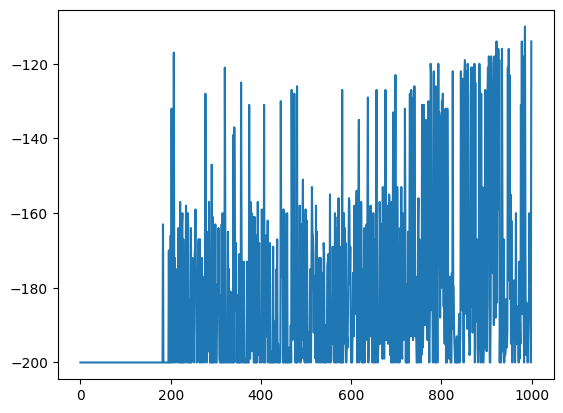

Experiment 1 done with average reward -184.942


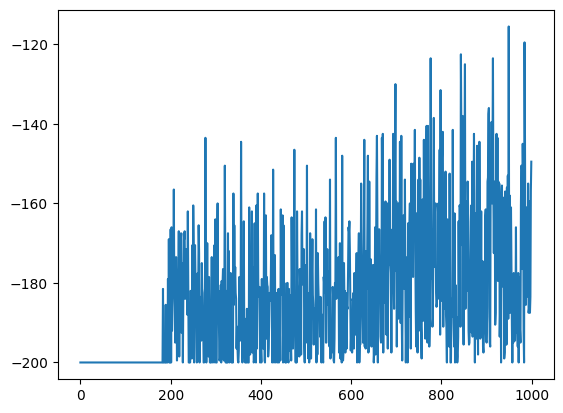

Experiment 2 done with average reward -183.88


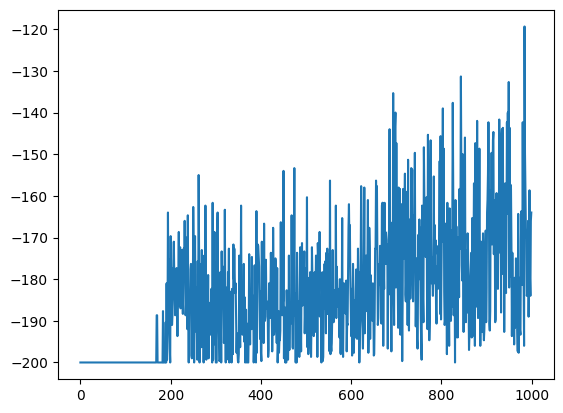

Experiment 3 done with average reward -184.746


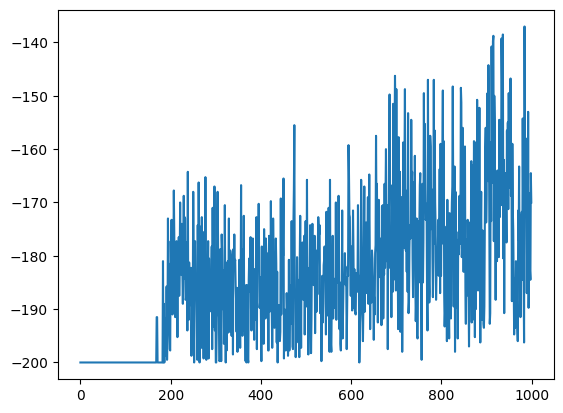

Experiment 4 done with average reward -182.705


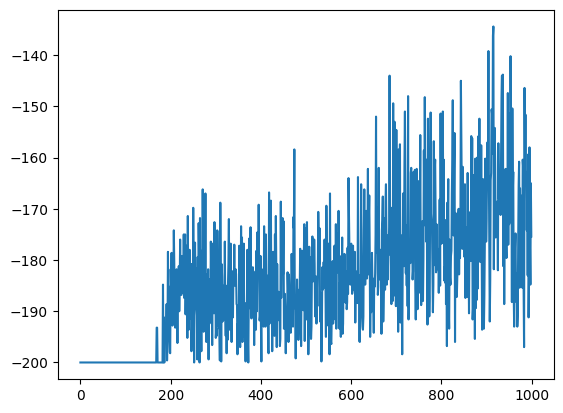

KeyboardInterrupt: 

In [244]:
avg_rewards = []
for experiment in range(50):
    rewards = q_learning(mtn_car, 1000, 1/(10*4), 0.99, 0.1,4,7)
    avg_rewards.append(rewards)
    print("Experiment", experiment, "done with average reward", np.mean(rewards))
    plt.plot(np.mean(avg_rewards, axis=0))
    plt.show()
avg_rewards = np.mean(avg_rewards, axis=0)
plt.plot(avg_rewards)
plt.show()

### 1.3 Expected SARSA with linear function approximation

## 2. Policy Gradient Theorem

## 3. Policy-based methods with linear function approximation